**Date**: 03/31/2022 (first draft); 04/07/2022 (modified)

**Authors**: 

Xiping Gong (Email: xipinggong@umass.edu)

[Jianhan Chen](https://people.chem.umass.edu/jchenlab/) (Email: jianhanc@umass.edu)

# Import packages

In [1]:
# This will import some necessary Python packages (required to run first)
# ---------------
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.display import Markdown
import mdtraj as md # data analysis
import glob

# Introduction

The HyRes model is a hybrid resolution coarse-grained model for conformational sampling of disordered proteins ([Liu and Chen, 2017](https://pubs.rsc.org/en/content/articlehtml/2017/cp/c7cp06736d#cit20)). This model was initially designed for the protein simulations, where all 20 natural amino acids have their own representation (Please see Figure 1 in Ref. 1), where the backbone atoms were kept in an atomistic level, while the sidechain atoms were grouped into one or several coarse-grain beans. In this way, the secondary structure information can be visualized in the HyRes model. Additionally, the Debye–Hückel-type electrostatic potential was applied to capature the salt and solvent effects. The additional backbone hydrogen bonding interactions were also used to balance the secondary structure propensities of proteins, especially for the disordered proteins.

However, the previous HyRes model only can be executed in the CPU devices and did not make use of the CHARMM GPU capability. Here, the OpenMM-derived GPU-HyRes model was implemented in the CHARMM program, and it was expected that the GPU-HyRes model can gain a significant speedup, especially for larger systems. In this tutorial, we will introduce the metholodogy of HyRes model first, and how the GPU-HyRes was implemented in the CHARMM, and then its implementing correctness and bechmarking were tested. Finally, some common examples was summaried to the users, including how to call the GPU-HyRes calculations, how to calcualte the energies and forces of a given conformation, and how to run the specific simulations, such as NVE and Langevin dynamic simulations.

**Reference**

[1] Liu and Chen, Phys. Chem. Chem. Phys., 2017, 19, 32421-32432; DOI: 10.1039/C7CP06736D

# Methodology

## Switching function applied for the cutoff scheme

The switching function applied in the cutoff computations is given by,

$sw(r, r_{off}, r_{on}) = 
step(r_{off}-r) + 
step(r-r_{on}) * [step(r_{off}-r) - step(r_{on}-r)] * \frac{(r_{off}^2-r^2)^2[(r_{off}^2-r^2) - 3*(r_{on}^2-r^2)]}{(r_{off}^2-r_{on}^2)^3} $, (1)

where step is a step function.

We did not implement the shift and force shift schemes for HyRes model, so this cutoff scheme is only one option to be used in the CHARMM input file.

**Rerference**

[1] Steinbach and Brooks, J. Comput. Chem., 1994, 15, 667-683 (DOI: https://doi.org/10.1002/jcc.540150702)

Switching function:  cutoff =  18.0 cuton =  16.0


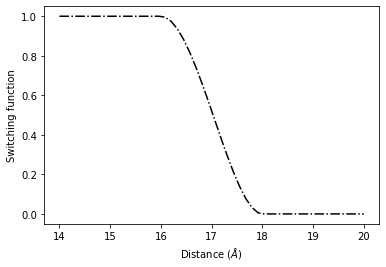

In [2]:
# the definition of switching function
# ------------------------------------
def step(x):
    """Defining a step function."""
    return np.where(x<0, 0.0, 1.0)

def sw(x, cutoff=18.0, cuton=16.0):
    """"Defining a switching function."""
    
    xoff2 = cutoff*cutoff - x*x
    xon2 = cuton*cuton - x*x
    xoffon2 = cutoff*cutoff - cuton*cuton
    result = xoff2*xoff2*(xoff2-3.0*xon2)/xoffon2**3
    result = step(cuton-x) + step(x-cuton)*(step(cutoff-x) - step(cuton-x)) * result
    return result


# plot switch function
# --------------------
x = np.linspace(14, 20, 50)
cutoff = 18.0
cuton = 16.0
y = np.zeros(x.shape)
k = 0
for xr in x:
    y[k] = sw(xr, cutoff=cutoff, cuton=cuton)
    k += 1
plt.plot(x, y, 'k-.')
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Switching function')
print('Switching function: ', 'cutoff = ', cutoff, 'cuton = ', cuton)

**Figure 1**. The switching function applied in the HyRes model. The cutoff and cuton distances
are 18 and 16 Å, respectively.

## Effective potential energy function

The HyRes model used both bonded and nonbonded terms, including the bonds, angles, dihedrals, improper dihedrals, backbone $\phi/\psi$ torsion cross-term; and the nonbonded terms have Lennard-Jones interactions, hydrogen bonding and electrostatic potentials. To capture some salt and solvent effect, the Debye–Hückel-type electrostatic potential and backbone hydrogen-bond potential are also used,

$U = U_{bond} + U_{angle} + U_{dihedral} + U_{improper} + U_{CMAP} + U_{LJ} + U_{hbond} + U_{elec}$. (2)

## Debye–Hückel-type electrostatic potential

Compared to the classical atomistic force field, the HyRes model used the screened Debye–Hückel-type potential as an electrostatic interaction.

$U_{elec} = \sum_{ij}\frac{q_iq_j}{4\pi\epsilon_r\epsilon_0r_{ij}}e^{-\frac{r_{ij}}{D}} sw(r_{ij}, r_{off}, r_{on})$, (3)

where $q_i$ is the charge of the CG bead i, $r_{ij}$ is the inter-charge distance, and $\epsilon_0$ is the permittivity
of vacuum. $D$ is the Debye screening length. At 300 K, $D$ (in Å) depends on the ionic strength ($I$,
in M) according to $\sqrt{9.48/I}$. The $\epsilon_r$ is the effective dielectric constant, and a final value, $\epsilon_r = 20$, was chosen in the HyRes model to capture the solvent effect.


## Backbone hydrogen-bond potential

$U_{Hbond}$ is applied on the peptide backbone N, H and O atoms, and depends on both the N–O
distance and O–H–N angle ($r$ and $\theta_{AHD}$ , respectively). $\sigma_{AD}$ is set to the ideal hydrogen bond
donor–acceptor distance of 2.9 Å and $\epsilon_{AD}$ is set to 1.50 kcal/mol ([Brooks, Bernard R., et al., J. Comput. Chem., 1983, 4, 187-217](https://onlinelibrary.wiley.com/doi/10.1002/jcc.540040211)).

$U_{hbond} = \sum_{AHD}\epsilon_{AD}[5(\frac{\sigma_{AD}}{r_{AD}})^{12} - 6(\frac{\sigma_{AD}}{r_{AD}})^{10}] sw(r_{AD}, r_{off}, r_{on}) * cos^4\theta_{AHD} * sw(cos\theta_{AHD},cos\theta_{off}, cos\theta_{on})$. (4)

# Implementations

## OpenMM custom forces

It is easier to use the OpenMM custom forces to accelerate the calculations of nonbonded potentials. For example, the
“CustomNonbondedForce” was used to describe the electrostatic potentials, which defines a
universal mathematical expression, $E = f(r)$, where $r$ is the inter-particle distance.

Additionally, the OpenMM provides the “CustomHbondForce” to support the hydrogen bonding
energy functions between each donor group and each acceptor group, $E = f({r_i}, {\theta_i}, {\phi_i})$,
where $f(...)$ is a user defined mathematical expression, which depends on an arbitrary set of
distance, angles, and dihedral angles.

## Implementations

Both custom forces have similar procedures. Here, we take the “CustomHbondForce” as an
example. We first need to create a CustomHbondForce object, passing an algebraic expression to
the constructor that defines the interaction energy between each donor and acceptor, and then
add this force object to the OpenMM force object. Then we can set up a cutoff method for the
nonbonded calculations and define the parameters. For example, we can define the parameters by
calling addGlobalParameter() to define global parameters and addPerDonorParameter() to define
per-donor parameters, or addPerAcceptorParameter() to define per-acceptor parameters. Once
we defined these parameters, then we need to add all donors and acceptors. For example, we can
call addDonor() and addAcceptor() to define donors and acceptors and specify their parameter
values. After a donor or acceptor has been added, you can modify its parameters by calling
setDonorParameters() or setAcceptorParameters(). These procedures can be found in the
[OpenMM documentation](http://docs.openmm.org/latest/api-c++/generated/CustomHbondForce.html).

## Pseudocode

        # Create a hbondforce object
        call OpenMM_CustomHbondForce_create (hbondforce, trim(formula))
        # Define the method to calculate the nonbonded interactions
        call OpenMM_CustomHbondForce_setNonbondedMethod (hbondforce, method)
        # Add the hbondforce into the OpenMM force
        iparam = OpenMM_System_addForce(system, transfer(hbondforce, OpenMM_Force(0)))
        # Add the global parameters
        iparam = OpenMM_CustomHbondForce_addGlobalParameter(hbondforce, ‘parameter’)
        # Add the acceptors or donors and their parameters
        iparam = OpenMM_CustomHbondForce_addPerDonorParameter(hbondforce, ‘parameter’)
        Do inx = 1, NDON # loop all donors
           iparam = OpenMM_CustomHbondForce_addDonor(hbondforce, inx1, inx2, inx3, params)
        EndDo
        iparam = OpenMM_CustomHbondForce_addPerAcceptorParameter(hbondforce, ‘parameter’)
        Do inx = 1, NDON # loop all donors
           iparam = OpenMM_CustomHbondForce_addAcceptor(hbondforce, inx1, inx2, inx3, params)
        EndDo
        ...
        # energy expression
        write(formula, '(15a)') &
            'epsilon*(5.0*(sigma/r)^12-6.0*(sigma/r)^10)*swrad*cosd^4*swang; ', &
            'swrad = step(rcuton-r)+step(r-rcuton)*(step(rcutoff-r)-step(rcuton-r))*', &
            'roff2*roff2*(roff2-3.0*ron2)/roffon2^3; ', &
            'roff2 = rcutoff*rcutoff-r*r; ', &
            'ron2 = rcuton*rcuton-r*r; ', &
            'roffon2 = rcutoff*rcutoff-rcuton*rcuton; ', &
            'rcutoff = CTOFHB; rcuton = CTONHB; r = distance(d1,a1); ', &
            'swang = step(cosdcuton-cosd)+step(cosd-cosdcuton)*(step(cosdcutoff-cosd)-step(cosdcuton-cosd))*', &
            'cosdoff2*cosdoff2*(cosdoff2-3.0*cosdon2)/cosdoffon2^3; ', &
            'cosdoff2 = cosdcutoff*cosdcutoff-cosd*cosd; ', &
            'cosdon2 = cosdcuton*cosdcuton-cosd*cosd; ', &
            'cosdoffon2 = cosdcutoff*cosdcutoff-cosdcuton*cosdcuton; ', &
            'cosdcutoff = -cos(CTOFHA); cosdcuton = -cos(CTONHA); cosd = cos(angle(d1,d2,a1)); ', &
            'sigma = 0.5*(sigmaD+sigmaA); ', &
            'epsilon = sqrt(epsilonD*epsilonA);'
        ...
        # The detailed implementation can be found in the CHARMM source code by calling the following command,
        grep -r '! AN EXAMPLE OF OPENMM CUSTOMFORCE' ~/charmm/source/*

# Correctness

To confirm the correctness of implementations, we took the full length of p53 protein as a test
model, to see whether the GPU calculations can reproduce the CPU calculations. First, the
atomistic forces were calculated from the CPU and CUDA calculations. Then, the NVE and Langevin dynamic
simulations were also used to confirm the correctness of protein dynamics.

    ! DH electrostatic potential
    nbond inbfrq -1
    NBOND atom switch cdie vdw vswitch -
          cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
          eps 20 ionc 0.15
    
    ! HB potential
    HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
       CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

## CPU vs. GPU forces

/home/ping/pikes_home/work/tutorial/hyres


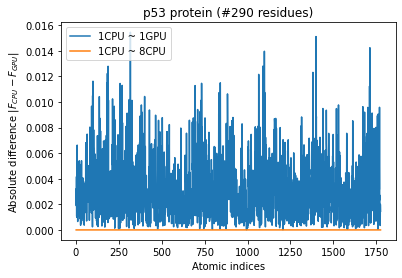

In [3]:
# CPU vs. GPU forces
# ------------------
# this is a hyrestutorial directory
%cd '/home/ping/pikes_home/work/tutorial/hyres'
forces1cpu = np.loadtxt('forces.1cpu.dat')
forces8cpu = np.loadtxt('forces.8cpu.dat')
forces1gpu = np.loadtxt('forces.1gpu.dat') # CUDA-mixed

inx = forces1cpu[:,0]
diff = np.sqrt(np.sum((forces1cpu[:,1:4]-forces1gpu[:,1:4])**2, axis=1))
plt.plot(inx, diff,label='1CPU ~ 1GPU')
diff = np.sqrt(np.sum((forces8cpu[:,1:4]-forces8cpu[:,1:4])**2, axis=1))
plt.plot(inx, diff,label='1CPU ~ 8CPU')

plt.xlabel('Atomic indices')
plt.ylabel('Absolute difference $|F_{CPU} - F_{GPU}|$')
plt.title('p53 protein (#290 residues)')
plt.legend()

**Figure 2**. The correctness of HyRes OpenMM implementations by confirming the protein forces.
The expected absolute difference should be closer to zero for all atomic indices.

## Energy conservation (NVE)

/home/ping/pikes_home/work/tutorial/hyres


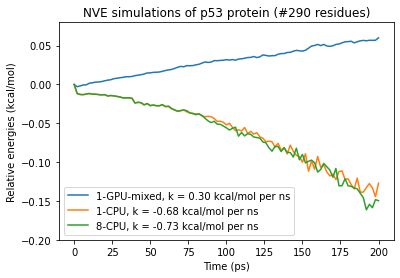

In [4]:
# NVE simulations
# ---------------
# timestep 0.002
%cd '/home/ping/pikes_home/work/tutorial/hyres'
start = 0
fmt = '{0:.2f}'
nve1gpu = np.loadtxt('nve.1gpu.dat')
k1 = np.polyfit(nve1gpu[start:,0], nve1gpu[start:,1], 1)
nve1cpu = np.loadtxt('nve.1cpu.dat')
k2 = np.polyfit(nve1cpu[start:,0], nve1cpu[start:,1], 1)
nve8cpu = np.loadtxt('nve.8cpu.dat')
k3 = np.polyfit(nve8cpu[start:,0], nve8cpu[start:,1], 1)

plt.plot(nve1gpu[start:,0], nve1gpu[start:,1]-nve1gpu[start,1],label='1-GPU-mixed, k = '+fmt.format(k1[0]*1000)+' kcal/mol per ns')
plt.plot(nve1cpu[start:,0], nve1cpu[start:,1]-nve1cpu[start,1],label='1-CPU, k = '+fmt.format(k2[0]*1000)+' kcal/mol per ns')
plt.plot(nve8cpu[start:,0], nve8cpu[start:,1]-nve8cpu[start,1],label='8-CPU, k = '+fmt.format(k3[0]*1000)+' kcal/mol per ns')
plt.xlabel('Time (ps)')
plt.ylabel('Relative energies (kcal/mol)')
plt.title('NVE simulations of p53 protein (#290 residues)')
plt.ylim([-0.2,0.08])
plt.legend()

**Figure 3**. NVE simulations of CPU and GPU calculations. The time step was set to 2 fs for the NVE simulations and the mixed precision was used in the GPU calculations.

According to the NVE simulations, the CPU and GPU calculations are almost energy-conserved.
We also investigated the effects of computational precisions on the energy
conservation by using three options (single, mixed, and double). We observed that the mixed and
double schemes performed pretty similarly, and single scheme was a little worsen.
After comparing with the computational efficiency, we strongly suggested using the mixed precision for all GPU calculations.

## Langevin dynamics


```
# Langevin dynamics (extracting data)
# -----------------------------------
wdir = '/home/ping/pikes_home/work/tutorial/hyres/'
%cd $wdir

# run Langevin dynamic simulations to obtain these trajectories first.
namearr = ['kid1.1cpu.[1-9].dcd', 'kid2.1cpu.[1-9].dcd',
          'kid1.8cpu.[1-9].dcd', 'kid2.8cpu.[1-9].dcd',
          'kid1.1gpu.[1-9].dcd', 'kid2.1gpu.[1-9].dcd',]

for name in namearr:
    print('\n')
    # native pdb and trajectories
    print('Extracting the native pdb and trajectory files >>')
    trajfiles = glob.glob(name) # each is 100 ns
    trajfiles = sorted(trajfiles)
    for k in range(0,len(trajfiles)):
        print('file '+str(k)+' > ', trajfiles[k])
    traj = md.load(trajfiles, top=name[0:4]+'.pdb')
    print('traj = ', traj)
    
    # calculating property: Helicity of each residue by a block averaging
    dssp = md.compute_dssp(traj) # it costs a lot
    dssp = np.where(dssp=='H', 1, 0)
    arr = dssp.T
    nblocks = 10
    lenBlock = int(arr.shape[-1] / nblocks)
    avg = np.average(np.reshape(arr[:,0:nblocks*lenBlock], (-1, nblocks, lenBlock)), axis=-1)
    sem = np.std(avg, ddof=1, axis=-1) / np.sqrt(nblocks) # standard error (SEM)
    avg = np.average(avg, axis=-1) # average (AVG)
    
    # save
    savepath = wdir+name[0:9]+'.helix'
    header = 'Helicity of KID; HyRes;'
    qdat = np.array([np.arange(0,len(avg)), avg, sem]).T
    np.savetxt(savepath, qdat, header=header, fmt='%10.5f')
    print('Saving AVG and SEM into '+ savepath)
```

/home/ping/pikes_home/work/tutorial/hyres


Text(0.5, 1.0, 'KID')

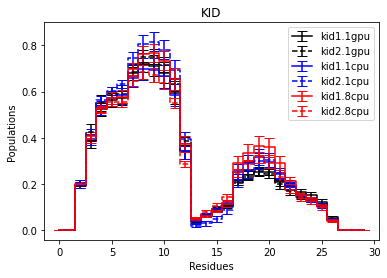

In [5]:
# Langevin dynamics (plotting)
# ----------------------------
%cd '/home/ping/pikes_home/work/tutorial/hyres'

# GPU (cons harm)
arr = np.loadtxt('kid1.1gpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='k-', label='kid1.1gpu', ds='steps-mid')
arr = np.loadtxt('kid2.1gpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='k--', label='kid2.1gpu', ds='steps-mid')

# 1-CPU
arr = np.loadtxt('kid1.1cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='b-', label='kid1.1cpu', ds='steps-mid')
arr = np.loadtxt('kid2.1cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='b--', label='kid2.1cpu', ds='steps-mid')

# 8-CPU
arr = np.loadtxt('kid1.8cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='r-', label='kid1.8cpu', ds='steps-mid')
arr = np.loadtxt('kid2.8cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='r--', label='kid2.8cpu', ds='steps-mid')

plt.legend() #loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residues')
plt.ylabel('Populations')
plt.title('KID')

**Figure 4**. The Langevin dynamics of KID proteins for 1-, 8-CPU and 1-GPU calculations. The
“kid1” and “kid2” simulations used the unfolded and folded initial structures, respectively.

I also tested the Langevin dynamics of KID protein for 1-, 8-CPU and 1-GPU calculations.
It was expected that their calculations should give the similar helicity distribution of
KID residues, and these results between CPU and GPU are pretty close. It suggested that the GPU dynamics can
reproduce the CPU dynamics.

# Benchmarking

## Performance


**Table 1**. The performance of CPU- and GPU-HyRes models (NVT langevin dynamics, dt = 2 fs).
The CPU name is "Intel(R) Xeon(R) Silver 4110 CPU @2.10GHz" and CUDA device name is "GeForce RTX 2080".
The number of residues of KID, p53-TAD, and p53 are 26, 61, and 290, respectively.

| Devices | KID (ns/day) | p53-TAD (ns/day) | Full p53 (ns/day) |
| :--- | --- | --- | --- |
| CPU-1 | 363 (1x) | 128 (1x) | 13 (1x) |
| CPU-2 | 632 (1.7x) | 228 (1.8x) | 25 (1.9x) |
| CPU-4 | 976 (2.7x) | 398 (3.1x) | 47 (3.5x) |
| CPU-8 | 1241 (3.4x) | 590 (4.6x) | 79 (6.1x) |
| CPU-16 | 1325 (3.7x) | 726 (5.7x) | 116 (9.0x) |
| GPU-1 (HyRes) | 2113 (5.8x) | 1697 (13.3x) | 992 (76.3x) |
| GPU-1 (no-HB) | 3100 (8.5x) | 2925 (22.9x) | 2230 (171.5x) |


Text(0.5, 1.0, 'GPU-HyRes')

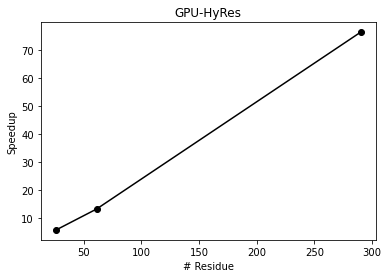

In [6]:
table1 = Markdown('''
**Table 1**. The performance of CPU- and GPU-HyRes models (NVT langevin dynamics, dt = 2 fs).
The CPU name is "Intel(R) Xeon(R) Silver 4110 CPU @2.10GHz" and CUDA device name is "GeForce RTX 2080".
The number of residues of KID, p53-TAD, and p53 are 26, 61, and 290, respectively.

| Devices | KID (ns/day) | p53-TAD (ns/day) | Full p53 (ns/day) |
| :--- | --- | --- | --- |
| CPU-1 | 363 (1x) | 128 (1x) | 13 (1x) |
| CPU-2 | 632 (1.7x) | 228 (1.8x) | 25 (1.9x) |
| CPU-4 | 976 (2.7x) | 398 (3.1x) | 47 (3.5x) |
| CPU-8 | 1241 (3.4x) | 590 (4.6x) | 79 (6.1x) |
| CPU-16 | 1325 (3.7x) | 726 (5.7x) | 116 (9.0x) |
| GPU-1 (HyRes) | 2113 (5.8x) | 1697 (13.3x) | 992 (76.3x) |
| GPU-1 (no-HB) | 3100 (8.5x) | 2925 (22.9x) | 2230 (171.5x) |
''')
display(table1)

plt.plot([26, 61, 290], [5.82, 13.26, 76.33], 'k-o')
plt.xlabel('# Residue')
plt.ylabel('Speedup')
plt.title('GPU-HyRes')

**Figure 5**. The speedup of GPU-HyRes model with the increase of systems size (# residue).

We also tested the effect of system size on the performance of HyRes model (Table 1). It can be
seen that the GPU performance becomes faster in the larger systems, and ~76x speedup can be observed in the full length of p53 protein. 
This is because that the speedup of GPU-HyRes calculations scales with the system size.

It also showed the comparisons with the GPU calculations without HB terms, we see
that the calculation of HB term is the dominating part in the GPU-HyRes model, which almost
takes up >50 % partitions. The “nvprof” tool was also used to qualify the performance of GPU-
HyRes model. we found that two HB GPU kernels took the major contribution to the
calculation, including the “computeDonorForces” and “computeAcceptorForces”, which are
much greater than the partition of “computeNonbonded” part.

## Profiling with nvprof

```
# nvprof /home/ping/programs/charmm/build/hyres/charmm openmm=1 -i nve.inp # HyRes
# -----------------------
==16272== Profiling application: /home/ping/programs/charmm/build/hyres/charmm openmm=1 -i nve.inp
==16272== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   37.31%  7.11465s    100503  70.790us  67.776us  289.96us  computeDonorForces
                   28.99%  5.52671s    100503  54.990us  53.153us  64.961us  computeAcceptorForces
                   18.26%  3.48077s    100503  34.633us  29.472us  46.753us  computeNonbonded
                    6.72%  1.28036s    101115  12.662us  1.6000us  18.752us  computeBondedForces
                    2.68%  510.67ms    100503  5.0810us  4.1920us  12.641us  findBlockBounds
                    1.17%  223.30ms    100503  2.2210us  2.0480us  12.064us  sortShortList2
                    1.08%  206.36ms    100100  2.0610us  1.9840us  11.233us  integrateVerletPart2
                    0.95%  180.36ms    100100  1.8010us  1.7280us  11.840us  integrateVerletPart1
                    0.69%  131.23ms    100503  1.3050us  1.2480us  11.616us  sortBoxData
                    0.57%  107.75ms    101217  1.0640us     832ns  13.056us  clearTwoBuffers
                    0.53%  101.87ms    100503  1.0130us     832ns  423.62us  findBlocksWithInteractions
                    0.51%  96.648ms    102537     942ns     768ns  12.192us  [CUDA memcpy DtoD]
                    0.46%  88.106ms    105141     837ns     288ns  16.864us  [CUDA memcpy DtoH]
                    0.05%  8.6726ms      1017  8.5270us  8.3840us  10.016us  reduceEnergy
                    0.04%  7.9949ms      2279  3.5080us     608ns  19.360us  [CUDA memcpy HtoD]
                    0.01%  1.4412ms      1017  1.4170us  1.2800us  12.192us  timeShiftVelocities
      API calls:   58.33%  12.3482s    100503  122.86us  1.4450us  672.01us  cuEventSynchronize
                   28.90%  6.11777s   1108087  5.5210us  3.9490us  1.8919ms  cuLaunchKernel
                    4.67%  988.52ms    102537  9.6400us  7.5140us  3.1371ms  cuMemcpyDtoDAsync
                    2.47%  523.28ms         2  261.64ms  245.90ms  277.39ms  cuCtxCreate
                    2.42%  512.58ms    100703  5.0890us  3.9930us  451.80us  cuMemcpyDtoHAsync
                    1.51%  320.30ms      4438  72.173us  16.880us  597.66us  cuMemcpyDtoH
                    0.80%  168.81ms    100503  1.6790us  1.2890us  718.30us  cuEventRecord
                    0.55%  115.44ms      2279  50.654us  4.9520us  57.480ms  cuMemcpyHtoD
                    0.25%  52.261ms    202596     257ns     161ns  458.99us  cuCtxSetCurrent
                    0.05%  11.338ms        17  666.94us  364.53us  1.6778ms  cuModuleLoad
                    0.02%  4.0982ms         4  1.0246ms  990.33us  1.0547ms  cuMemHostAlloc
                    0.01%  2.9158ms       124  23.514us  4.3260us  193.07us  cuMemAlloc
                    0.00%  871.97us         2  435.99us  407.52us  464.46us  cuMemFreeHost
                    0.00%  768.06us         4  192.01us     424ns  766.48us  cuDriverGetVersion
                    0.00%  424.52us        54  7.8610us  4.4610us  111.72us  cuMemFree
                    0.00%  92.859us         2  46.429us  45.992us  46.867us  cuDeviceGetName
                    0.00%  39.437us        75     525ns     242ns  2.9010us  cuModuleGetFunction
                    0.00%  10.633us         4  2.6580us  1.2760us  5.8650us  cuEventCreate
                    0.00%  7.7380us         1  7.7380us  7.7380us  7.7380us  cuDeviceGetPCIBusId
                    0.00%  6.1270us        11     557ns     182ns     833ns  cuDeviceGetAttribute
                    0.00%  5.4640us         2  2.7320us  1.0170us  4.4470us  cuCtxSetLimit
                    0.00%  5.1000us         1  5.1000us  5.1000us  5.1000us  cuEventDestroy
                    0.00%  4.5500us         4  1.1370us     409ns  1.6410us  cuDeviceGetCount
                    0.00%  3.1030us         3  1.0340us     532ns  1.6610us  cuDeviceGet
                    0.00%  2.1340us         2  1.0670us  1.0650us  1.0690us  cuCtxGetLimit
                    0.00%  1.9760us         2     988ns     903ns  1.0730us  cuCtxSetCacheConfig
                    0.00%  1.9280us         2     964ns     882ns  1.0460us  cuDeviceComputeCapability
```

# Examples using the CHARMM program

Here, we provided the input files used to generate the above data.


In [7]:
%cd '/home/ping/pikes_home/work/tutorial/hyres'

print('\n # The following are the topology and parameter files and the CHARMM input files >> ')
%ls -all *.inp *.pdb *.psf
print('\n # The data files generated')
%ls -all *.dat
print('\n # The calculated helicity of KID residues')
%ls -all *.helix

/home/ping/pikes_home/work/tutorial/hyres

 # The following are the topology and parameter files and the CHARMM input files >> 
-rw-r--r-- 1 1012 1004    918 Apr  7 15:38 ener.inp
-rw-r----- 1 1012 1004 136881 Apr  7 15:43 fp53.pdb
-rw-r----- 1 1012 1004 495195 Apr  7 15:43 fp53.psf
-rw-r--r-- 1 1012 1004  35710 Mar 31 14:30 hb2.0.inp
-rw-r--r-- 1 1012 1004  14374 Apr  7 15:43 kid1.pdb
-rw-r--r-- 1 1012 1004  50161 Apr  7 15:43 kid1.psf
-rw-r--r-- 1 1012 1004  14374 Apr  7 15:43 kid2.pdb
-rw-r--r-- 1 1012 1004  50161 Apr  7 15:43 kid2.psf
-rw-r--r-- 1 1012 1004   2116 Mar 31 14:30 langevin.inp
-rw-r----- 1 1012 1004   1134 Mar 31 14:30 nve.inp
-rw-r----- 1 1012 1004  36567 Mar 31 14:30 param_idpcg.inp
-rw-r----- 1 1012 1004  19681 Mar 31 14:30 top_idpcg.inp
-rw-r--r-- 1 1012 1004  19726 Mar 31 14:30 top-idpcg-sasa.inp

 # The data files generated
-rw-r--r-- 1 1012 1004 53011 Apr  7 15:52 forces.1cpu.dat
-rw-r--r-- 1 1012 1004 53010 Apr  7 15:52 forces.1gpu.dat
-rw-r--r-- 1 1012 1004 53

## Energies and forces

The CHARMM input file is "**ener.inp**" showed as below,

```
if @?pdbid eq 0     set pdbid = fp53
if @?openmm eq 0    set openmm = 0

read  rtf card name top_idpcg.inp
read para card name param_idpcg.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! OpenMM
! ------
if openmm eq 0 then
   omm platform CUDA precision mixed deviceid 0
   omm on
endif

! energy and forces
! ---------------------
set natom = ?natom
energy
coor force comp
print coor comp sele bynu 1:@natom end

stop
```

Execute the following commands in a bash environment,

```
$CHARMM openmm=1 -i ener.inp > ener.1gpu.out
$CHARMM openmm=0 -i ener.inp > ener.1cpu.out
$mpirun -np 8 $CHARMM openmm=0 -i ener.inp > ener.8cpu.out

grep ' P53  ' ener.1gpu.out | awk '{print $1, $5, $6, $7}' | head -1775 > forces.1gpu.dat # natom = 1775
grep ' P53  ' ener.1cpu.out | awk '{print $1, $5, $6, $7}' | head -1775 > forces.1cpu.dat
grep ' P53  ' ener.8cpu.out | awk '{print $1, $5, $6, $7}' | head -1775 > forces.8cpu.dat

output>>
1) energies by checking out the outfile file
==> 1gpu <==
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER CROSS:           CMAPs        PMF1D        PMF2D        PRIMO
ENER EXTERN:        VDWaals         ELEC       HBONds          ASP         USER
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0      2.81856      0.00000      0.39962
ENER INTERN>       48.28796    365.66936      0.00000    148.38173    120.04808
ENER CROSS>       -15.72816      0.00000      0.00000      0.00000
ENER EXTERN>     -542.03040    -20.40126   -101.40874      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
==> 8cpu <==
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER CROSS:           CMAPs        PMF1D        PMF2D        PRIMO
ENER EXTERN:        VDWaals         ELEC       HBONds          ASP         USER
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0      2.81864      0.00000      0.39965
ENER INTERN>       48.28790    365.66973      0.00000    148.38178    120.04793
ENER CROSS>       -15.72816      0.00000      0.00000      0.00000
ENER EXTERN>     -562.43186      0.00000   -101.40870      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
==> 1cpu <==
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER CROSS:           CMAPs        PMF1D        PMF2D        PRIMO
ENER EXTERN:        VDWaals         ELEC       HBONds          ASP         USER
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0      2.81864      0.00000      0.39965
ENER INTERN>       48.28790    365.66973      0.00000    148.38178    120.04793
ENER CROSS>       -15.72816      0.00000      0.00000      0.00000
ENER EXTERN>     -562.43186      0.00000   -101.40870      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------

2) forces by running "head forces.*.dat"
==> forces.1cpu.dat <==
1 0.02010 -0.04612 0.08278
2 0.00881 -0.00535 0.03896
3 -0.49517 0.21991 -0.26026
4 -0.00539 -0.01192 -0.01481
5 0.89434 0.24586 -0.00883
6 -0.45259 -0.28168 0.14091
7 0.89068 -0.59616 0.25633
8 -0.96629 0.21089 -0.17960
9 0.11157 0.42956 0.14659
10 0.00753 -0.07655 0.22543

==> forces.1gpu.dat <==
1 0.02244 -0.04498 0.08463
2 0.00739 -0.00605 0.03998
3 -0.49249 0.21771 -0.26256
4 -0.00583 -0.01102 -0.01446
5 0.88928 0.24799 -0.01162
6 -0.45220 -0.28220 0.14164
7 0.89713 -0.59491 0.25717
8 -0.96810 0.21113 -0.18011
9 0.10736 0.42737 0.14898
10 0.00818 -0.07654 0.22554

==> forces.8cpu.dat <==
1 0.02010 -0.04612 0.08278
2 0.00881 -0.00535 0.03896
3 -0.49517 0.21991 -0.26026
4 -0.00539 -0.01192 -0.01481
5 0.89434 0.24586 -0.00883
6 -0.45259 -0.28168 0.14091
7 0.89068 -0.59616 0.25633
8 -0.96629 0.21089 -0.17960
9 0.11157 0.42956 0.14659
10 0.00753 -0.07655 0.22543

```

## NVE simulation

The CHARMM input file is "**nve.inp**" showed as below,
```
if @?pdbid eq 0     set pdbid = fp53
if @?openmm eq 0    set openmm = 0

read  rtf card name top_idpcg.inp
read para card name param_idpcg.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! NVE simulation
!-------------------------------------------------------
set nstep = 100000
! 1) CPU
if openmm eq 0 then
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         inbfrq -1    ihbfrq -1 -
         ilbfrq 1000 nprint 1000

endif

! 2) CUDA
if openmm eq 1 then
   omm platform CUDA precision mixed deviceid 0
   omm on
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         ilbfrq 1000 nprint 1000
endif

```

Typing the following commands in a bash environment,
```
! running simulations
$CHARMM openmm=1 -i nve.inp > nve.1gpu.out
$CHARMM openmm=0 -i nve.inp > nve.1cpu.out
$mpirun -np 8 $CHARMM openmm=0 -i nve.inp > nve.8cpu.out # mpirun is an executable program

! analysis
grep 'DYNA>' nve.1gpu.out | awk '{print $3, $4}' > nve.1gpu.dat
grep 'DYNA>' nve.1cpu.out | awk '{print $3, $4}' > nve.1cpu.dat
grep 'DYNA>' nve.8cpu.out | awk '{print $3, $4}' > nve.8cpu.dat
```

## Langevin dynamic simulation

The CHARMM input file is "**langevin.inp**" showed as below,
```
if @?pdbid eq 0     set pdbid = fp53
if @?openmm eq 0    set openmm = 0
if @?label eq 0     set label = cpu
if @?deviceid eq 0  set deviceid = 0

read  rtf card name top-idpcg-sasa.inp
read para card name hb2.0.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! OpenMM set up
! -------------
energy
if openmm eq 1 then
   omm platform CUDA precision mixed deviceid @deviceid
   omm on
   energy
endif

! Langevin dynamics
!-------------------------------------------------------
shake tolerance 1.0e-06 bonh param
set timestep = 0.002
energy

scalar FBETA set 0.2 select .not. hydrogen end
set nstep = 50000000 ! 50000000: 100 ns
set nprint = 50000 ! 50000: 1 print / 100 ps
set nblocks = 9 ! 9 x 100 ns

set run = 1
open writ card unit 9  name @pdbid.@label.@run.rest
open writ file unit 10 name @pdbid.@label.@run.dcd
DYNAMICS LEAP LANGEVIN start timestep @timestep nstep @nstep -
     iunread -1 iunwri 9 iuncrd 10 -
     nprint @nprint nsavc @nprint nsavv -1 isvfrq @nprint iprfrq @nstep -
     inbfrq -1 ihbfrq -1 ILBFRQ -1 -
     firstt 300.0 finalt 300.0 tbath 300.0 rbuf 0.0
! cont.
label dynloop
   set prerun = @run
   incr run by 1
   open read card unit 8  name @pdbid.@label.@prerun.rest
   open writ card unit 9  name @pdbid.@label.@run.rest
   open writ file unit 10 name @pdbid.@label.@run.dcd
   DYNAMICS LEAP LANGEVIN restart timestep @timestep nstep @nstep -
      iunread 8 iunwri 9 iuncrd 10 -
      nprint @nprint nsavc @nprint nsavv -1 isvfrq @nprint iprfrq @nstep -
      inbfrq -1 ihbfrq -1 ILBFRQ -1 -
      firstt 300.0 finalt 300.0 tbath 300.0 rbuf 0.0
if @run lt @nblocks goto dynloop

stop

```

Typing the following commands to run Langevin dynamic simulations,
```
pdbid=kid1; label=1cpu; 
$CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out
pdbid=kid2; label=1cpu; 
$CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out

pdbid=kid1; label=8cpu; 
$mpirun -np 8 $CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out
pdbid=kid2; label=8cpu; 
$mpirun -np 8 $CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out

pdbid=kid1; label=1gpu; 
$CHARMM label=$label pdbid=$pdbid openmm=1 deviceid=0 -i langevin.inp > $pdbid.$label.out
pdbid=kid2; label=1gpu; 
$CHARMM label=$label pdbid=$pdbid openmm=1 deviceid=1 -i langevin.inp > $pdbid.$label.out

```

# Questions

**Q1: What CHARMM version can we use to run GPU-HyRes calculations?**

It requires version > c47. If you are not sure, then using some examples to test whether it supports, or not.
Also, the HyRes model seems requires a higher version of OpenMM (>7.5.0), because there was a bug in the CustomHbondForce in previous OpenMM versions.

**Q2: How to run the GPU-HyRes calculations @pikes workstation?**

Using the following commands before running any GPU-HyRes simulations or putting them into your ~/.bashrc file.
```
# @pikes, faster node
# -------------------
# GCC
module load gcc/6.1.0
export GCCTK=/cm/local/apps/gcc/6.1.0
export CC=$GCCTK/bin/gcc
export CXX=$GCCTK/bin/g++
# OPENMM
LOCAL=/home/ping/programs/openmm/build/7.5.0
export OPENMM_DIR=$LOCAL
export OPENMM_LIB_PATH=$LOCAL/lib
export OPENMM_INCLUDE_PATH=$LOCAL/include/
export OPENMM_PLUGIN_DIR=$LOCAL/lib/plugins
# CUDA
module load cuda/10.1.243
export CUDATK=/cm/shared/apps/cuda/10.1.243
export PATH=$CUDATK/lib64:$PATH
export PATH=$CUDATK/lib64/stubs:$PATH
export PATH=$CUDATK/bin:$PATH
export OPENMM_CUDA_COMPILER=$CUDATK/bin/nvcc

CHARMM='/home/ping/programs/charmm/build/hyres/charmm'
mpirun='/home/ping/programs/openmpi/openmpi-3.0.0/build/bin/mpirun'
```

**Q3: How to quickly know I can run GPU-HyRes calculations?**

Go to the tutorial folder and run directly the ener.inp CHARMM input file.
